# Analyse bone morphological parameters using condacolab and PyImageJ

## Dependecies
Numpy

OpenJDK

Maven

PyImageJ

OpenJDK

iPyWidgets

SciKit-Image

VTK

Stackview 

ipycanvas

data analysis: Pandas

## Installing dependencies

### `conda install -c conda-forge openjdk maven`
### `pip install pyimagej`
### `pip install notebook numpy ipywidgets scikit-image stackview vtk`

or

### `conda install -r c_requirements.txt`
### `pip install -r p_requirements.txt`

### Import general dependencies

In [1]:
import numpy as np
import os

### Set work directory to current directory

In [ ]:
work_dir = os.getcwd()
print(work_dir)

### Import and initiate ImageJ with BoneJ

In [3]:
import imagej
ij = imagej.init('sc.fiji:fiji:2.5.0+org.bonej:bonej-plugins:7.0.13')
print(ij.getVersion())

2.5.0/1.53r


## Import data
### Import tif with ImageJ and print dimensions to check

In [4]:
img = ij.io().open('GF_100_Tibiotarsus_Dist_U_cropped_and_purified.tif')
print(img.shape)

(583, 576, 1024)


### Show individual slice

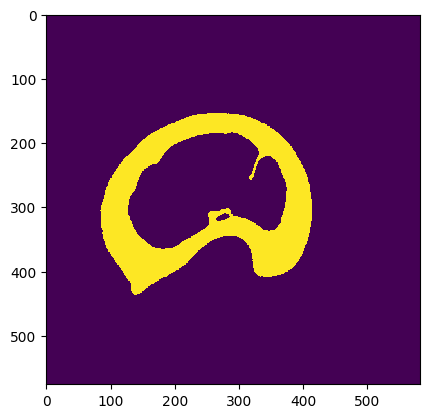

In [5]:
ij.py.show(img[:,:,300])

### Build image slice viewer using iPyWidgets

In [6]:
import ipywidgets

def plane(image, pos):
    """
    Slices an image plane at the given position.
    :param image: the image to slice
    :param pos: a dictionary from dimensional axis label to element index for that dimension
    """
    # Convert pos dictionary to position indices in dimension order.
    # See https://stackoverflow.com/q/39474396/1207769.
    p = tuple(pos[image.dims[d]] if image.dims[d] in pos else slice(None) for d in range(image.ndim))
    return image[p]

def _axis_index(image, *options):
    axes = tuple(d for d in range(image.ndim) if image.dims[d].lower() in options)
    if len(axes) == 0:
        raise ValueError(f"Image has no {options[0]} axis!")
    return axes[0]

def ndshow(image, cmap=None, x_axis=None, y_axis=None, immediate=False):
    if not hasattr(image, 'dims'):
        # We need dimensional axis labels!
        raise TypeError("Metadata-rich image required")

    # Infer X and/or Y axes as needed.
    if x_axis is None:
        x_axis = _axis_index(image, "x", "col")
    if y_axis is None:
        y_axis = _axis_index(image, "y", "row")

    # Build ipywidgets sliders, one per non-planar dimension.
    widgets = {}
    for d in range(image.ndim):
        if d == x_axis or d == y_axis:
            continue
        label = image.dims[d]
        widgets[label] = ipywidgets.IntSlider(description=label, max=image.shape[d]-1, continuous_update=immediate)

    # Create image plot with interactive sliders.
    def recalc(**kwargs):
        print("displaying")
        ij.py.show(plane(image, kwargs), cmap=cmap)
    ipywidgets.interact(recalc, **widgets)



### Display data by invoking ndshow

In [7]:
ndshow(img, immediate=True)

interactive(children=(IntSlider(value=0, description='Z', max=1023), Output()), _dom_classes=('widget-interact…

## Analysis - Use ScyJava.jImport to interpret Java based functions in Python

### Import and test Java functions using jImport

In [8]:
from scyjava import jimport
Runtime = jimport('java.lang.Runtime')
print(Runtime.getRuntime().maxMemory() // (2**20), " MB available to Java")

8108  MB available to Java


### Convert image to imagePlus format, needed for running ImageJ analysis

In [9]:
imp = ij.py.to_imageplus(img)
print(imp.getAllStatistics())

Operating in headless mode - the original ImageJ will have limited functionality.


stats[count=335808, mean=23.18105881932533, min=0.0, max=255.0]


###  Run ImageJ/Fiji functions 

Syntax can be recorded in ImageJ/Fiji by going to _Plugins > Macros > Record_

Set _Record_ to Python to get the correct syntax. The Threshold command below was generated by going _Image > Adjust > Threshold_ and running it with the recorder active.

In [10]:
ij.IJ.run(imp, "Measure", "")

Operating in headless mode - the IJ class will not be fully functional.
[java.lang.Enum.toString]  	Area	Mean	Min	Max[java.lang.Enum.toString] 
[java.lang.Enum.toString] 1	335808	23.181	0	255[java.lang.Enum.toString] 


### For plugins it gets a bit trickier
Import the plugin wrapper and the shared results table from org.bonej using jimport

Set up the wrapper to run the plugin on your image

Use .get() to run the command - the results will be dropped in the shared table

Fetch the table and extract your results

In [11]:
fractionwrapper = jimport('org.bonej.wrapperPlugins.ElementFractionWrapper')
sharedtable = jimport('org.bonej.utilities.SharedTable')
volumefraction_run = ij.command().run(fractionwrapper, True, ["inputImage",img])
volumefraction_run.get()
ftable = sharedtable.getTable()
print(ftable)
volumefraction = np.mean(ftable[2])
print(volumefraction)

[[5.1955372E7], [3.43867392E8], [0.15109130207961097]]
0.15109130207961097


### BV/TV is wonky in BoneJ though
Volumefraction uses the total image value as the TV instead of the total volume of the bone (bone + lumen). Dedicated ROI analyses do not work well in BoneJ/ImageJ/Fiji, so we are limited to an improvised approach. This can be addressed by using volumefraction twice. Run volumefraction to get the bone volume (BV against the total background (TV). Now fill the bone to make a solid bone that represents the total bone volume and run volume fraction again to get the full bone (BV) against the background (TV). Use the solid BV as your TV against your initial true BV to calculate the actual BV/TV.

_Note that other BoneJ analyses will encounter similar ROI problems_

_Implementing this here is technically a work in progress, but the ROI limitations most likely make BoneJ unsuitable as a proper tool for automizing this workflow._


## Stackview

In [13]:
from skimage.io import imread
image = imread('GF_100_Tibiotarsus_Dist_U_cropped_and_purified.tif')

In [14]:
image.shape

(1024, 576, 583)

In [15]:
import stackview
stackview.slice(image, continuous_update=True)

In [16]:
import numpy as np
from skimage import measure

r_factor = 2
reduce = measure.block_reduce(image, block_size=(r_factor,r_factor,r_factor), func=np.mean)

In [17]:
verts, faces, normals, values = measure._marching_cubes_lewiner.marching_cubes(reduce, 250)
print(verts.shape)

(2787438, 3)


### Write STL to work dir

In [18]:
from vtktools import Writer

writerT = Writer(v=verts, f=faces)
writerT.write(f'{work_dir}\\test.stl')

## Works in progress

### Visualize STL - work in progress

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
# Display resulting triangular mesh using Matplotlib. This can also be done
# with mayavi (see skimage.measure.marching_cubes_lewiner docstring).
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# # Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])
mesh.set_edgecolor('k')
ax.add_collection3d(mesh)

plt.tight_layout()
plt.show()

### More ImageJ analyses - work in progress

In [ ]:
# https://javadoc.scijava.org/BoneJ/index.html?org/bonej/wrapperPlugins/package-summary.html
fractionwrapper = jimport('org.bonej.wrapperPlugins.ElementFractionWrapper')
thicknesswrapper = jimport('org.bonej.wrapperPlugins.ThicknessWrapper')
anisotropywrapper = jimport('org.bonej.wrapperPlugins.AnisotropyWrapper')
sharedtable = jimport('org.bonej.utilities.SharedTable')

#fraction_run = ij.command().run(fractionwrapper, True, ["inputImage",imp])
fraction_run = ij.command().run('org.bonej.wrapperPlugins.ElementFractionWrapper', True, ["inputImage",imp])
fraction_run.get()
table = sharedtable.getTable()
print(table)
volumefraction = np.mean(table[2])
print(volumefraction)

#ani_run = ij.command().run(anisotropywrapper, True, ["inputImage", imp, "directions", 2000, "lines", 10000, "samplingIncrement", 1.73, "recommendedMin", False, "printRadii", False, "printEigens", False, "displayMILVectors", False, "printMILVectorsToTable", False])
#ani_run.get()
#table = sharedtable.getTable()
#anisotropy = np.mean(table[3])
#print(anisotropy)

#thick_run = ij.command().run(thicknesswrapper,False,["inputImage", imp, "showMaps", True, "maskArtefacts", True])
#thick_run.get()
#table = sharedtable.getTable()
#thickness = np.mean(table[3])
#print(thickness)



#IJ.run("Area/Volume fraction", "inputimage=net.imagej.ImgPlus@d362953");
#IJ.run("Anisotropy", "inputimage=net.imagej.ImgPlus@d362953 directions=2000 lines=10000 samplingincrement=1.73 recommendedmin=false printradii=false printeigens=false displaymilvectors=false printmilvectorstotable=false");

### More BoneJ analyses - work in progress

In [ ]:
anisotropywrapper = jimport('org.bonej.wrapperPlugins.AnisotropyWrapper')
sharedtable = jimport('org.bonej.utilities.SharedTable')
ani_run = ij.command().run(anisotropywrapper, True, ["inputImage", img, "directions", 2000, "lines", 10000, "samplingIncrement", 1.73, "recommendedMin", False, "printRadii", False, "printEigens", False, "displayMILVectors", False])
ani_run.get()
atable = sharedtable.getTable()
print(atable)
anisotropy = np.mean(atable[2])
print(anisotropy)

In [ ]:
thicknesswrapper = jimport('org.bonej.wrapperPlugins.ThicknessWrapper')
sharedtable = jimport('org.bonej.utilities.SharedTable')

thicknesswrapper = ij.command().run(thicknesswrapper,False,["inputImage", img, "showMaps", True, "maskArtefacts", True])
wrapperInstance = thicknesswrapper.get()
ttable = sharedtable.getTable()
print(ttable)

trabecular_map = wrapperInstance.getOutput("trabecularMap");

IJ.save(trabecular_map, f"{work_dir}\\test_image_new.tif")

In [ ]:
ImagePlus = jimport("ij.ImagePlus")

Prefs = jimport('ij.Prefs')
Prefs.blackBackground = True

img_thresh = np.zeros((img.shape))

for i in range(0,img.shape[2]):

    imp_i = ij.py.to_imageplus(img[:, :, i])

    print(f'Iteration {i}/{img.shape[2]}', end='\r')

    ij.IJ.setRawThreshold(imp_i, 17, 255)

    imp_i_thresh = ImagePlus("thresh-mask", imp_i.createThresholdMask())
    ij.IJ.run(imp_i, "Close", "")

    #ij.py.show(imp_i)
    

    img_i_t = ij.py.to_dataset(imp_i_thresh)

    res = np.array(imp_i_thresh.getProcessor().getPixels()).reshape(img[:, :, i].shape)
    ij.py.show(res)
    
    img_thresh[:, :, i] = res

    if i == int(img.shape[2]/2):
        print('')
        print(f'Slide number: {i}')
        ij.py.show(img_thresh[:,:,i])
    
#ij.IJ.run(imp, "Measure", "")